<a href="https://colab.research.google.com/github/vineetsalar88/ResrachPaper2/blob/master/21Dec25Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsResnet.csv")

class_map = {
    "Score 1": 0,
    "Score 2": 1,
    "Score 3": 2,
    "Score 4": 3,
    "Score 5": 4,
    "Score 6": 5,
    "Score 7": 6
}

df["label"] = df["label"].map(class_map)
df.to_csv("/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsImagenet.csv", index=False)

In [14]:
#Custom Dataset to read images + CSV
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageCSVDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset

dataset = ImageCSVDataset(
    csv_file="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsImagenet.csv",
    image_dir="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images",
    transform=transform
)

dataset_size = len(dataset)  # Assuming 'dataset' is your ImageFolder dataset
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.2 * dataset_size)  # 20% for validation
#test_size = dataset_size - train_size - val_size  # Remaining 10% for testing


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)



In [16]:
#Create Dataset & DataLoader
from torch.utils.data import DataLoader

dataset = ImageCSVDataset(
    csv_file="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsImagenet.csv",
    image_dir="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images",
    transform=transform
)

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)



| Part               | Status             |
| ------------------ | ------------------ |
| ResNet Conv layers | ❄️ Frozen          |
| BatchNorm          | ❄️ Frozen          |
| FC layer           | 🔥 Trainable       |
| Optimizer          | FC parameters only |


In [17]:
#Load ResNet18 & freeze feature extractor
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(pretrained=True)

# 🔒 Freeze all convolution layers
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
#Replace classifier for 7 classes
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)
for name, param in model.named_parameters():
    print(name, param.requires_grad)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

In [19]:
#Loss & optimizer (only classifier trained)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),  # 👈 only classifier
    lr=1e-3
)


In [20]:
print("Train dataset size:", len(train_loader.dataset))
print("Number of train batches:", len(train_loader))


Train dataset size: 690
Number of train batches: 44


In [24]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
checkpoint_path = "/content/drive/MyDrive/Models/21Dec25Resnet18_checkpoint.pth"

# ======================
# 🔹 LOAD CHECKPOINT
# ======================
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]

    train_losses = checkpoint["train_losses"]
    train_accuracies = checkpoint["train_accuracies"]

    print(f"✅ Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    train_losses = []
    train_accuracies = []

val_accuracies = []

# ======================
# 🔹 TRAINING LOOP
# ======================
for epoch in range(start_epoch, epochs):

    # -------- TRAIN --------
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0


    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * train_correct /train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}%"
    )

    # ======================
    # 🔹 SAVE CHECKPOINT
    # ======================
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "train_accuracies": train_accuracies
    }, checkpoint_path)


Epoch [1/20] Train Loss: 1.2491 | Train Acc: 52.75% | Val Loss: 1.0347 | Val Acc: 55.80%
Epoch [2/20] Train Loss: 1.1702 | Train Acc: 56.23% | Val Loss: 1.0275 | Val Acc: 59.42%
Epoch [3/20] Train Loss: 1.0793 | Train Acc: 58.70% | Val Loss: 0.8873 | Val Acc: 63.77%
Epoch [4/20] Train Loss: 1.0402 | Train Acc: 60.58% | Val Loss: 0.8963 | Val Acc: 70.29%
Epoch [5/20] Train Loss: 0.9978 | Train Acc: 64.06% | Val Loss: 0.8252 | Val Acc: 70.29%
Epoch [6/20] Train Loss: 0.9227 | Train Acc: 65.80% | Val Loss: 0.7987 | Val Acc: 72.46%
Epoch [7/20] Train Loss: 0.9773 | Train Acc: 63.19% | Val Loss: 0.8098 | Val Acc: 68.12%
Epoch [8/20] Train Loss: 0.8900 | Train Acc: 68.26% | Val Loss: 0.7442 | Val Acc: 76.09%
Epoch [9/20] Train Loss: 0.8543 | Train Acc: 68.99% | Val Loss: 0.8387 | Val Acc: 63.04%
Epoch [10/20] Train Loss: 0.8824 | Train Acc: 67.39% | Val Loss: 0.6692 | Val Acc: 80.43%
Epoch [11/20] Train Loss: 0.8156 | Train Acc: 71.45% | Val Loss: 0.6374 | Val Acc: 78.99%
Epoch [12/20] Train

ValueError: x and y must have same first dimension, but have shapes (40,) and (0,)

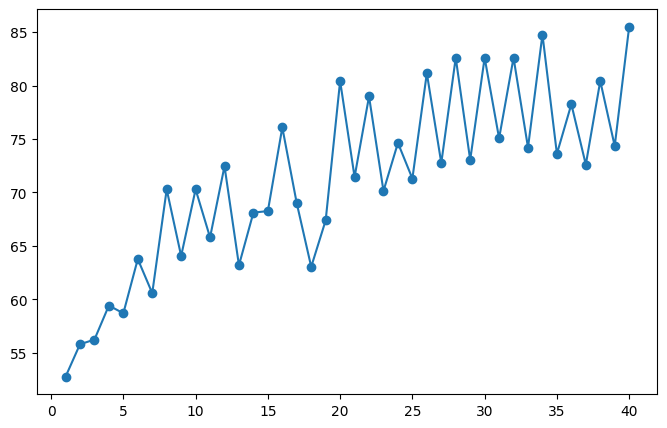

In [27]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, marker='o', label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[[ 8  0  1  0  0  0]
 [ 0 26  1  0  0  0]
 [ 0  2 34  4  0  0]
 [ 2  3  3 35  3  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  1  6]]


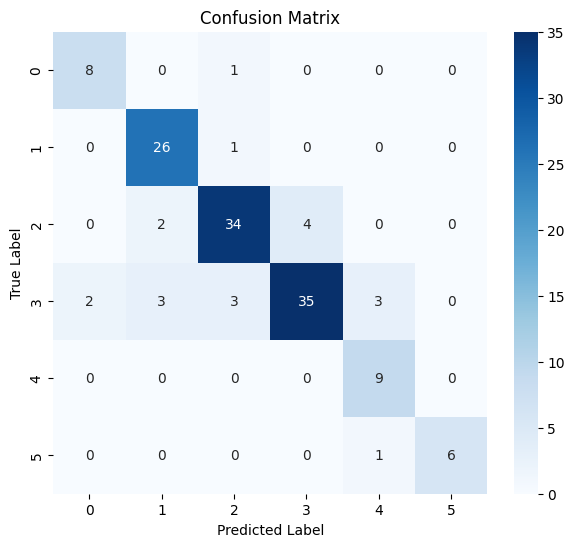

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
print(cm)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
